Импорты и настройки

In [121]:
# import sys
# sys.path.insert(0, 'C://Users//Adminn//Downloads')
# from tqdm import tqdm
# import datetime as dtime
# from scipy.stats import norm
# import scipy.stats as stats
# from statsmodels. stats.multicomp import pairwise_tukeyhsd

import random
import math
from glob import glob
from pprint import pprint
from time import time
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [122]:
# cd Telegram Desktop

Парсинг данных и очистка

In [123]:
df = pd.read_csv('csv/data_test.csv')

df.date = pd.to_datetime(df.date)
df['click_rate'] = df['clicks']/df['impressions']
df= df[(df['clicks']>0) | (df['impressions']>100)]

df = df.drop('campaign_id',axis=1)
df

,platform,campaign_name,date,impressions,clicks,click_rate
0,yandex direct,Венарус | Фармацевты | Баннеры | База Брефи,2023-04-23,35423,109,0.003077
1,yandex direct,Дексонал | Фармацевты | Баннеры | База Брефи,2023-04-23,13654,159,0.011645
2,yandex direct,Венарус | Фармацевты | Баннеры | База БФГ,2023-04-23,20100,58,0.002886
3,yandex direct,Дексонал | Фармацевты | Баннеры | База БФГ,2023-04-23,3459,31,0.008962
4,yandex direct,"ВА036 | Венарус, Венапрокт | Хирурги, проктоло...",2023-04-23,4061,29,0.007141
...,...,...,...,...,...,...
91922,my target,diclofenac-akos_mt_cpc_multiformat_base_neurol...,2022-07-31,741,6,0.008097
91936,my target,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,962,4,0.004158
91937,my target,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,175,1,0.005714
91938,my target,venarus_angiorus_mt_cpm_carousel_base_pharmacy...,2022-07-31,21167,27,0.001276


Выделим отдельные капании по наименованию препарата и ЦА

In [124]:
dexo = df.loc[(df.campaign_name.str.contains('dexonal')) | (df.campaign_name.str.contains('Дексонал'))]
dexo_thera = dexo.loc[(dexo.campaign_name.str.contains('therapist')) | (dexo.campaign_name.str.contains('Терапевт'))]

diclo = df.loc[(df.campaign_name.str.contains('Диклофенак-Акос')) | (df.campaign_name.str.contains('diclofenac-akos'))]
diclo_thera = diclo.loc[(diclo.campaign_name.str.contains('therapist')) | (diclo.campaign_name.str.contains('Терапевт'))]

df = df.groupby('date').sum().reset_index()

Суммы показов для кампаний дексонала

In [125]:
dexo_thera.groupby('campaign_name').impressions.sum().sort_values()

campaign_name
dexonal_mt_cpc_multiformat_base_therapists_breffi    102490
dexonal_mt_cpm_multiformat_base_therapists_breffi    125777
Дексонал  | Терапевты | База Брефи                   210841
Дексонал  | Терапевты | Баннеры | База БФГ           763021
Дексонал  | Терапевты | Баннеры | База Брефи         938907
Name: impressions, dtype: int64

Разделение на номера кампаний

In [126]:
def add_campaign_numbers(dataframe, window=30): #Окно между кампаниями я установил в 30 дней, тк это число показалось мне наиболее оптимальным
    dataframe = dataframe.sort_values('date')
    current_campaign = 0
    previous_date = None

    campaign_numbers = []

    for date in dataframe['date']:
        if previous_date is None or (date - previous_date).days > window:
            current_campaign += 1
        campaign_numbers.append(current_campaign)
        previous_date = date

    dataframe['campaign_number'] = campaign_numbers
    
    return dataframe

 Некоторые кампании одного и того же лекарства наслаиваются друг на друга. Это проблема для функции отделения групп, и я не смог учесть это. В любом случае, как мне кажется, если это в рамках одного препарата, то две маленькие кампании, идущие одновременно, действительно стоит объединить. Для всего датасета сразу можно будет это сделать только сгруппировав по новым категориям: Все названия кампаний привести к стандартизированному виду "Препарат | врачи". Это to do мне на завтра

 Some Thoughts от Григория: это имеет место, только если мы сможем уговорить биофарму, что так действительно правильно и они будут также делать у себя в документах, иначе мы просто будем обучать предсказательную модель на данных, которых никогда не будет существовать, а также построим на них весь анализ

 Добавил следующую функцию, чтобы показать, что если не соединять, как предлагает Сергей, то на выходе с отбрасыванием рядов, где меньше 10 элементов получи всего 2 ряда

In [137]:
def split_dataframe_by_campaign(dataframe, column_name='campaign_name', min_rows=10):
    unique_campaigns = dataframe[column_name].unique()
    dfs = []

    for campaign in unique_campaigns:
        campaign_df = dataframe[dataframe[column_name] == campaign].copy()
        if len(campaign_df) >= min_rows:
            dfs.append(campaign_df)

    return dfs

In [138]:
len(split_dataframe_by_campaign(df))

2

In [127]:
dexo_thera = dexo_thera.groupby('date').sum().reset_index()
dexo = dexo.groupby('date').sum().reset_index()

diclo_thera = diclo_thera.groupby('date').sum().reset_index()
diclo = diclo.groupby('date').sum().reset_index()

In [128]:
dexo_thera = add_campaign_numbers(dexo_thera)# Отделяем разные кампании
dexo = add_campaign_numbers(dexo)

diclo_thera = add_campaign_numbers(diclo_thera)
diclo = add_campaign_numbers(diclo)

Визуализация. Оптимизировал код Сергея

In [129]:
def plot(dataframe, column_name='clicks', rolling_window=1): # r_w = 1 == no rolling mean
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe = dataframe.sort_values(['campaign_number', 'date'])
    dataframe['rolled_mean'] = dataframe.groupby('campaign_number')[column_name].rolling(window=rolling_window, min_periods=rolling_window).mean().reset_index(level=0, drop=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for campaign_number, data in dataframe.groupby('campaign_number'):
        ax.scatter(data['date'], data['rolled_mean'], label=f'Campaign {campaign_number}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Impressions')
    ax.set_ylabel(f'Rolled Mean {column_name} (Window={rolling_window})')
    ax.set_title(f'Scatter Plot of {column_name} for {dataframe.campaign_name[0]}')

    ax.legend()
    plt.show()

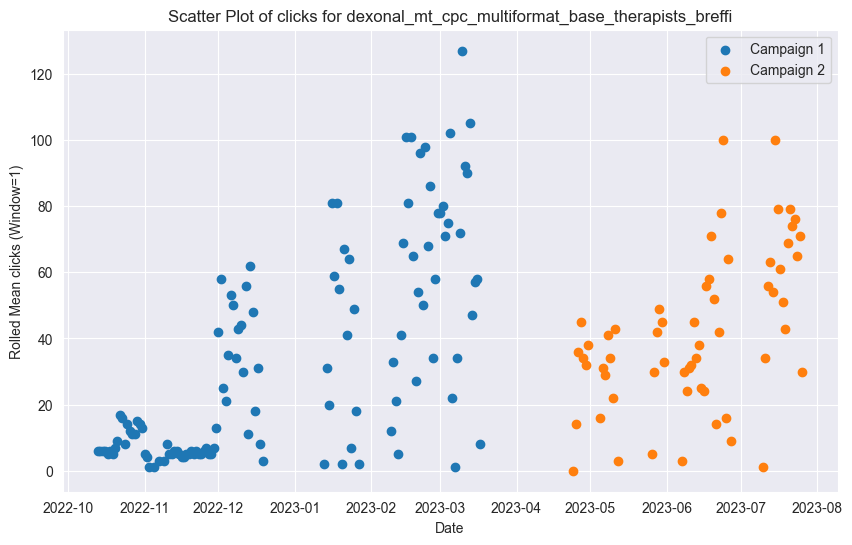

In [132]:
plot(dexo_thera)

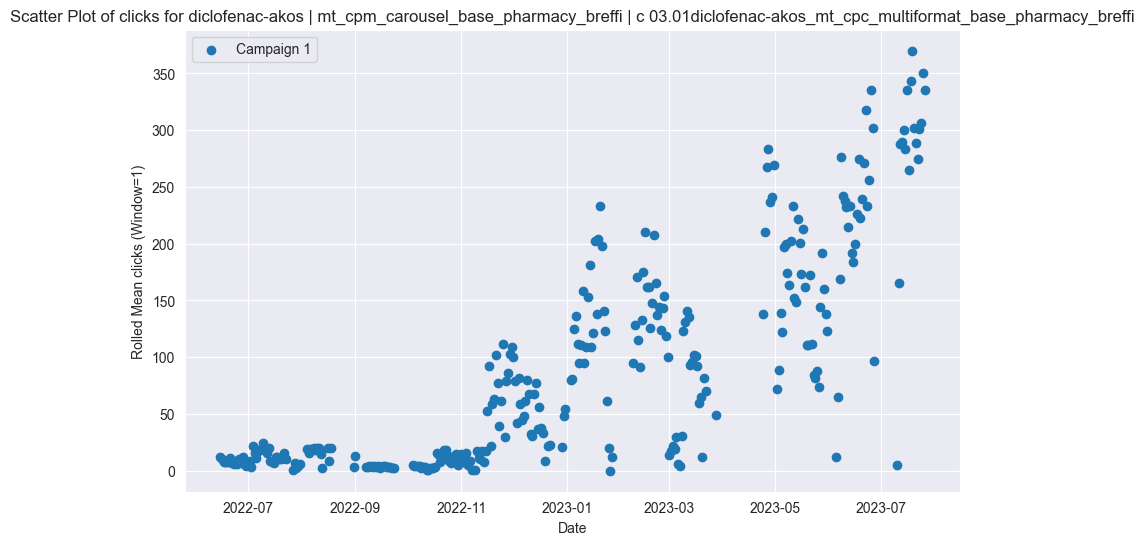

In [131]:
plot(diclo)

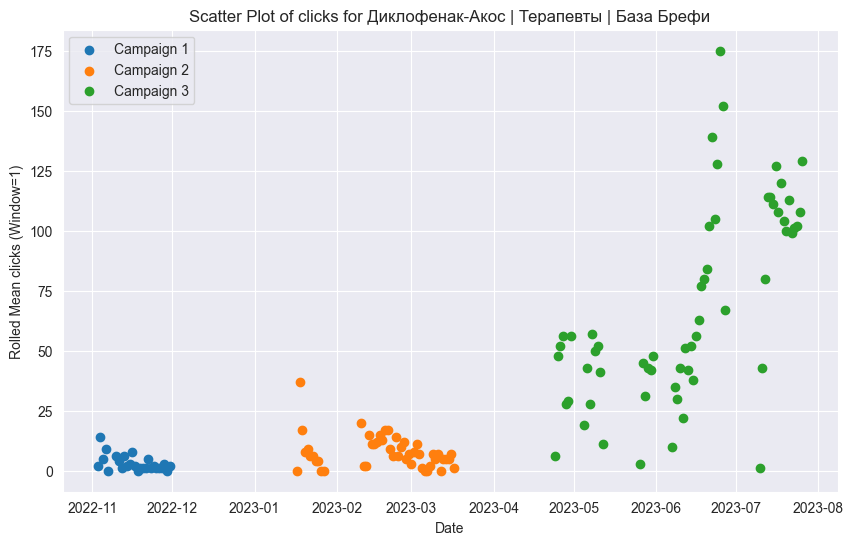

In [135]:
plot(diclo_thera)

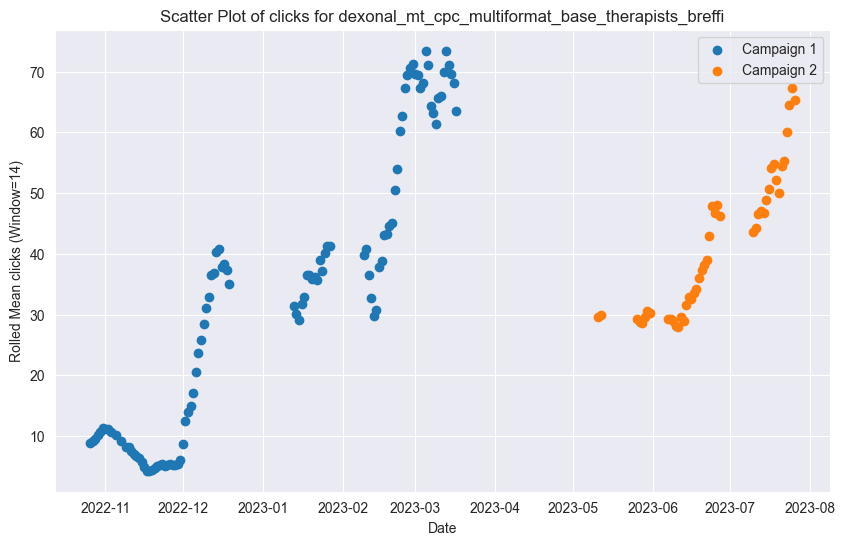

In [139]:
plot(dexo_thera, rolling_window=14)

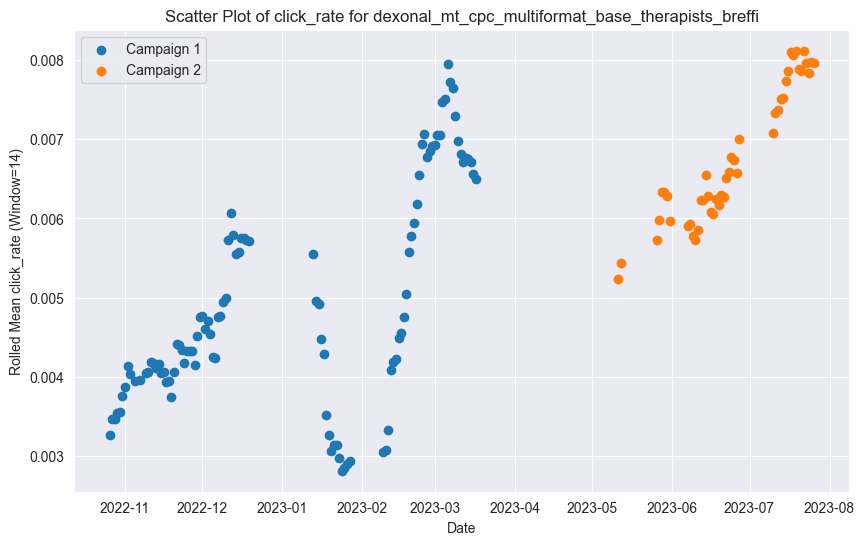

In [141]:
plot(dexo_thera, 'click_rate', rolling_window=14)

In [142]:
dexo_thera[(dexo_thera['campaign_name']=='Дексонал  | Терапевты | Баннеры | База Брефи')&(dexo_thera['impressions']>100)].sort_values(by='date').head()

,date,platform,campaign_name,impressions,clicks,click_rate,campaign_number
65,2023-01-13,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,731,2,0.002736,1
66,2023-01-14,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,12461,31,0.002488,1
67,2023-01-15,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,4759,20,0.004203,1
68,2023-01-16,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,29433,81,0.002752,1
69,2023-01-17,yandex direct,Дексонал | Терапевты | Баннеры | База Брефи,18819,59,0.003135,1


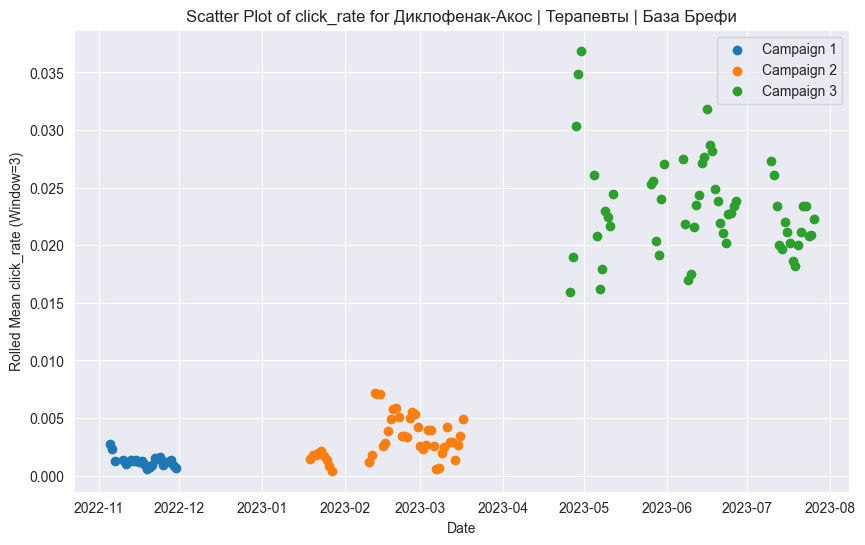

In [143]:
plot(diclo_thera, 'click_rate', rolling_window=3)

In [131]:
diclo_thera.groupby(['date','campaign_id'],as_index=False).sum()

,date,campaign_id,impressions,clicks,click_rate,campaign_number
0,2022-11-03,80102700,651,2,0.003072,1
1,2022-11-04,80102700,4423,14,0.003165,1
2,2022-11-05,80102700,2599,5,0.001924,1
3,2022-11-06,80102700,4887,9,0.001842,1
4,2022-11-07,80102700,327,0,0.000000,1
...,...,...,...,...,...,...
220,2023-07-24,86809161,8506,76,0.008935,9
221,2023-07-25,86809100,3326,38,0.011425,9
222,2023-07-25,86809161,4662,70,0.015015,9
223,2023-07-26,86809100,3648,45,0.012336,9


In [134]:
diclo_thera.head(50)

,platform,campaign_id,campaign_name,date,impressions,clicks,click_rate,campaign_number
65241,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-03,651,2,0.003072,1
65404,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-04,4423,14,0.003165,1
65721,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-05,2599,5,0.001924,1
65884,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-06,4887,9,0.001842,1
66354,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-07,327,0,0.000000,1
1507,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-10,2593,6,0.002314,2
2833,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-11,5037,4,0.000794,2
4452,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-12,2541,1,0.000394,2
5941,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-13,2057,6,0.002917,2
7224,yandex direct,80102700,Диклофенак-Акос | Терапевты | База Брефи,2022-11-14,4194,2,0.000477,2


In [118]:
diclo_thera.campaign_name.value_counts()

СВ003 | Диклофенак-Акос | Терапевты | Баннеры | База Breffi    59
СВ003 | Диклофенак-Акос | Терапевты | Баннеры | База БФГ       57
Диклофенак-Акос | Терапевты | Баннеры | База Брефи             47
Диклофенак-Акос | Терапевты | Баннеры | База БФГ               36
Диклофенак-Акос | Терапевты | База Брефи                       26
Name: campaign_name, dtype: int64

In [119]:
df

,platform,campaign_id,campaign_name,date,impressions,clicks,click_rate
0,yandex direct,75993195,Венарус | Фармацевты | Баннеры | База Брефи,2023-04-23,35423,109,0.003077
1,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-04-23,13654,159,0.011645
2,yandex direct,82468420,Венарус | Фармацевты | Баннеры | База БФГ,2023-04-23,20100,58,0.002886
3,yandex direct,82469257,Дексонал | Фармацевты | Баннеры | База БФГ,2023-04-23,3459,31,0.008962
4,yandex direct,84389757,"ВА036 | Венарус, Венапрокт | Хирурги, проктоло...",2023-04-23,4061,29,0.007141
...,...,...,...,...,...,...,...
91922,my target,56531009,diclofenac-akos_mt_cpc_multiformat_base_neurol...,2022-07-31,741,6,0.008097
91936,my target,58007934,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,962,4,0.004158
91937,my target,58008074,venarus_angiorus_mt_cpc_multiformat_base_pharm...,2022-07-31,175,1,0.005714
91938,my target,58008562,venarus_angiorus_mt_cpm_carousel_base_pharmacy...,2022-07-31,21167,27,0.001276


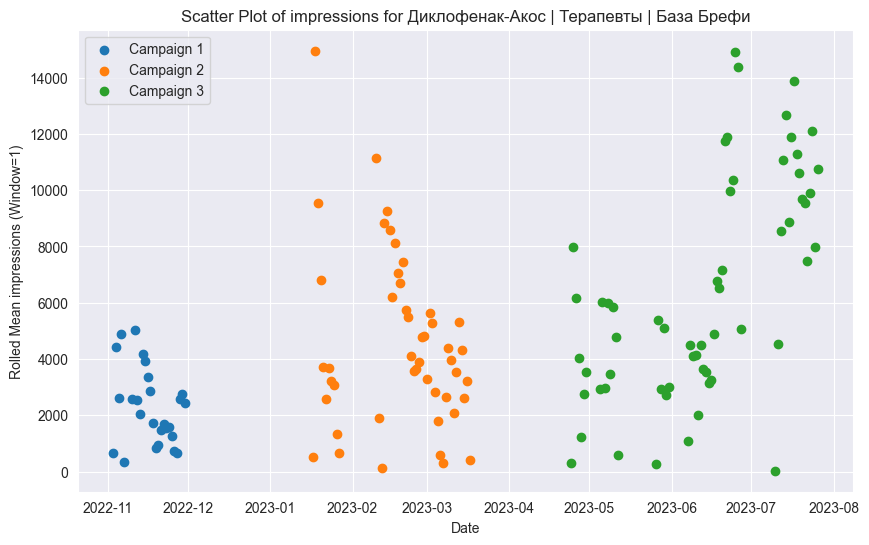

In [144]:
plot(diclo_thera, 'impressions', rolling_window=1)

In [147]:
diclo_thera.groupby('campaign_number').head().click_rate.mean()

0.00675615287648682

In [151]:
diclo_thera.groupby('campaign_number').apply(lambda group: group.head(5)['click_rate'].mean())

campaign_number
1    0.002001
2    0.001379
3    0.001570
4    0.004300
5    0.009578
6    0.007997
7    0.010804
8    0.009143
9    0.014032
dtype: float64

In [148]:
diclo_thera.groupby('campaign_number').tail().click_rate.mean()

0.008421424009779003

In [171]:
diclo.groupby('campaign_number').apply(lambda group: group.head(5)['click_rate'].mean()).mean()

0.004564235645679865

In [172]:
diclo.groupby('campaign_number').apply(lambda group: group.tail(5)['click_rate'].mean()).mean()

0.004190880889842965

In [174]:
dexo.groupby('campaign_number').apply(lambda group: group.head(5)['click_rate'].mean()).mean()

0.003514605516021033

In [173]:
dexo.groupby('campaign_number').apply(lambda group: group.tail(5)['click_rate'].mean()).mean()

0.00438462347104577

In [146]:
plot_rolled_mean(diclo, 'click_rate', window_size=1)

TypeError: plot() got an unexpected keyword argument 'window_size'

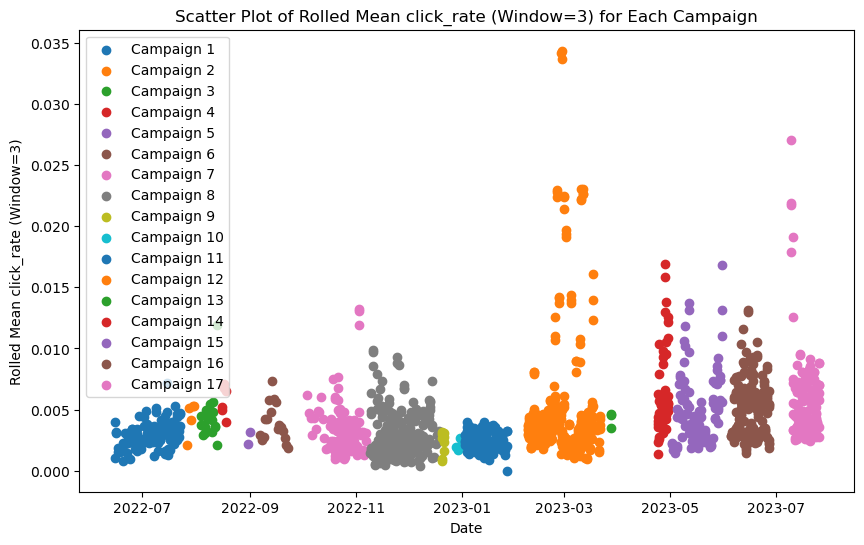

In [160]:
plot_rolled_mean(diclo[diclo['click_rate'] <0.1], 'click_rate', window_size=3)

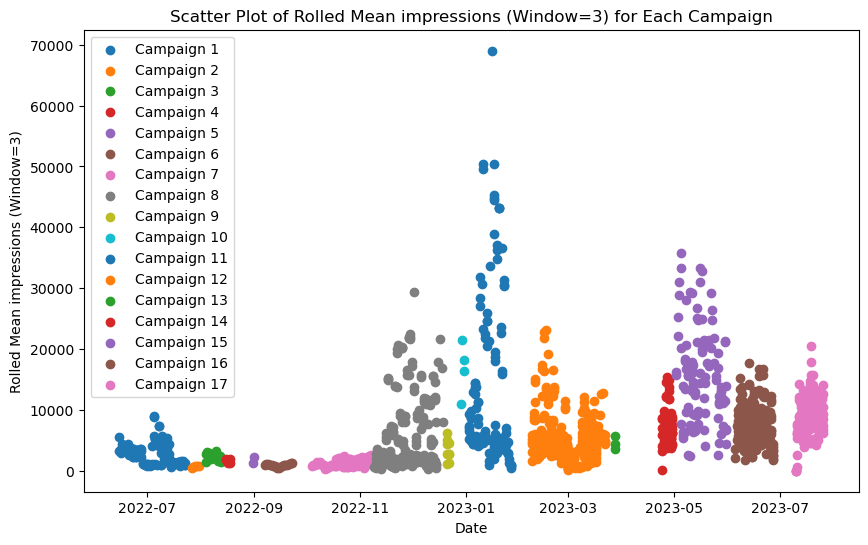

In [192]:
plot_rolled_mean(diclo, 'impressions', window_size=3)#Гипотеза: как соотносится большое(от 15-20к) кол-во показов и клик рейт 

In [99]:
#rolled_th_1 = dexo_thera[(dexo_thera['campaign_name']=='Дексонал  | Терапевты | Баннеры | База Брефи')&(dexo_thera['impressions']>100)].sort_values(by='date').rolling(window=7).mean().reset_index()
#sns.scatterplot(data = dexo_thera[(dexo_thera['campaign_name']=='dexonal_mt_cpc_multiformat_base_therapists_breffi')&(dexo_thera['impressions']>100)].sort_values(by='date'), x ='date',y='click_rate')

In [87]:
#dexo_thera[(dexo_thera['campaign_name']=='dexonal_mt_cpc_multiformat_base_therapists_breffi')&(dexo_thera['impressions']>100)].sort_values(by='impressions')

In [88]:
#sns.scatterplot(data = dexo_thera[(dexo_thera['campaign_name']=='dexonal_mt_cpc_multiformat_base_therapists_breffi')&(dexo_thera['impressions']>100)].sort_values(by='date'), x ='date',y='impressions')

In [89]:
#df.loc[((df.campaign_name.str.contains('dexonal')) | (df.campaign_name.str.contains('Дексонал'))) &((df.campaign_name.str.contains('therapist')) | (df.campaign_name.str.contains('Терапевт'))),'campaign_name'] = 'Дексонал  | Терапевты'

In [90]:
#df[df['campaign_name']=='Дексонал  | Терапевты']

In [191]:
df.campaign_name.unique()

array(['Венарус | Фармацевты | Баннеры | База Брефи',
       'Дексонал | Фармацевты | Баннеры | База Брефи',
       'Венарус | Фармацевты | Баннеры | База БФГ',
       'Дексонал | Фармацевты | Баннеры | База БФГ',
       'ВА036 | Венарус, Венапрокт | Хирурги, проктологи, колопроктологи | Баннеры | База Брефи',
       'ВА036 | Венарус, Венапрокт | Сосудистые хирурги, флебологи | Баннеры | База Брефи',
       'Максилак | Педиатры | Баннеры | База БФГ',
       'Максилак | Педиатры | Баннеры | База Бреффи',
       'ЕВ040_Акнауцер | Фармацевты | Баннеры | База БФГ',
       'СВ001 | Необутин | Гастро | Баннеры gif | База БФГ',
       'СВ001 | Необутин | Гастро | Баннеры gif | База Breffi',
       'Необутин | Гастро | Баннеры | База Брефи',
       'Кагоцел | Фармацевты | Баннеры | База Брефи',
       'Диклофенак-Акос | Терапевты | Баннеры | База Брефи',
       'Дексонал  | Терапевты | Баннеры | База Брефи',
       'Диклофенак-Акос | Фармацевты | Баннеры | База Брефи',
       'Кагоцел, Эльмуци

In [ ]:
def add_campaign_numbers_modified(df): #Что-то я тут явно напутал
    
    df['date'] = pd.to_datetime(df['date'])

   
    df = df.sort_values(['date', 'campaign_id'])

    
    current_campaign = 0
    previous_date = None
    previous_campaign_ids = set()

    
    campaign_numbers = []

    # Iterate through the sorted dates
    for date, campaign_id in zip(df['date'], df['campaign_id']):
        if previous_date is None or (date - previous_date).days > 1:
            current_campaign += 1
            previous_campaign_ids.clear()  
        elif campaign_id not in previous_campaign_ids:
            current_campaign += 1
            previous_campaign_ids.clear()  
        
        campaign_numbers.append(current_campaign)
        previous_date = date
        previous_campaign_ids.add(campaign_id)

    
    df['campaign_number'] = campaign_numbers
    
    return df